In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import itertools
import os
from itertools import combinations
import math

In [19]:
def is_isosceles(matrix):
    ones = np.argwhere(matrix == 1)
    for comb in itertools.combinations(ones, 3):
        comb = np.array(comb)
        distances = np.sqrt(np.sum((comb - comb[:, np.newaxis])**2, axis=-1))
        if np.allclose(distances[0], distances[1]) or np.allclose(distances[1], distances[2]) or np.allclose(distances[0], distances[2]):
            # Remove the smallest number of points required to make the triangle non-isosceles
            for i in range(3):
                if np.allclose(distances[i], distances[(i+1)%3]):
                    # remove point i
                    matrix[tuple(comb[i])] = 0
                    return True, matrix
    return False, matrix


In [20]:

def plot_board(matrix):

    n = len(matrix)
    data = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if matrix[i][j] == 1:
                data[i][j] = 1
    sns.set_style("whitegrid", {'axes.grid': False})
    sns.heatmap(data, cmap='Oranges', square=True, cbar=False, linewidth=1,
                linecolor='gray', annot=False, fmt='g')



In [41]:
def read_timeline(n):
    # filename = f'{n}x{n}_best_species_timeline.txt'
    filename = f'torus_grid_{str(n)}.txt'
    filepath = os.path.join('Data', filename)
    with open(filepath, 'r') as f:
        timeline = f.read()
    return timeline

def count_ones(matrix):
    return np.sum(matrix)

def get_unique_rotations(matrix):
    rotations = []
    for i in range(4):
        rotated = np.rot90(matrix, i)
        if not any(np.array_equal(rotated, r) for r in rotations):
            rotations.append(rotated)
    return rotations

def parse_timeline(n):
    timeline = read_timeline(n)

    # timeline = timeline.replace('[', '').replace(']', '').replace(',', '').replace('1.', '1').replace('0.', '0').replace(' ', '').replace('\n', '')
    timeline = timeline.replace('0', '1').replace('·', '0').replace('\n', '')


    # Split the timeline into distinct nxn numpy matrices

    matrices = []
    for i in range(len(timeline) // (n**2)):
        matrix = np.zeros((n, n))
        for j in range(n):
            for k in range(n):
                print(i,j,k)
                matrix[j][k] = int(timeline[i*n**2 + j*n + k])
        matrices.append(matrix)

    return matrices

def visualize_boards(n):
    matrices = parse_timeline(n)
    max_ones = max(np.count_nonzero(matrix == 1) for matrix in matrices)

    # Visualize the matrix with the most ones
    for matrix in matrices:
        if np.count_nonzero(matrix == 1) == max_ones:
            flag, temp_matrix = is_isosceles(matrix)
            if not flag:
                plot_board(matrix)
                break
            else:
                plot_board(temp_matrix)
        


Number of ones:  13.0


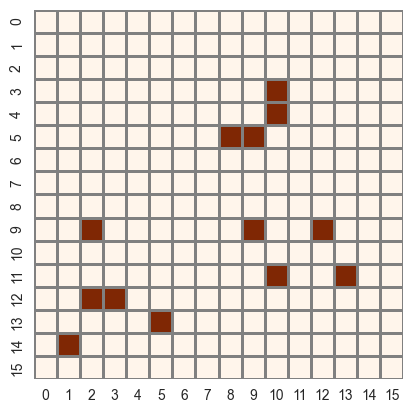

In [54]:
# Example usage
n = 16
matrix = parse_timeline(n)
visualize_boards(n)
print("Number of ones: ", count_ones(matrix))

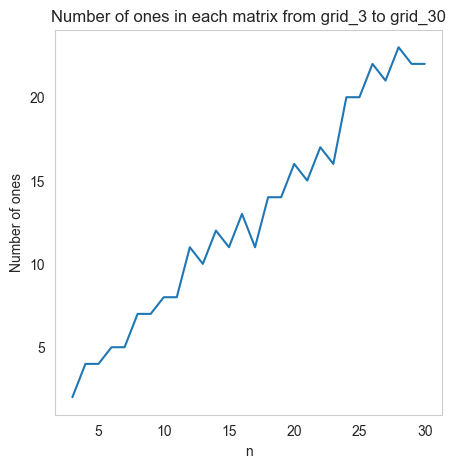

In [55]:
# Plot the number of ones in each matrix from grid_3 to grid_30

ones = []
for i in range(3, 31):
    matrices = parse_timeline(i)
    ones.append([count_ones(matrix) for matrix in matrices])

ones = np.array(ones).reshape(-1,1) 

plt.figure(figsize=(5, 5))
plt.plot(range(3, 31), ones)
plt.xlabel('n')
plt.ylabel('Number of ones')
plt.title('Number of ones in each matrix from grid_3 to grid_30')
plt.show()


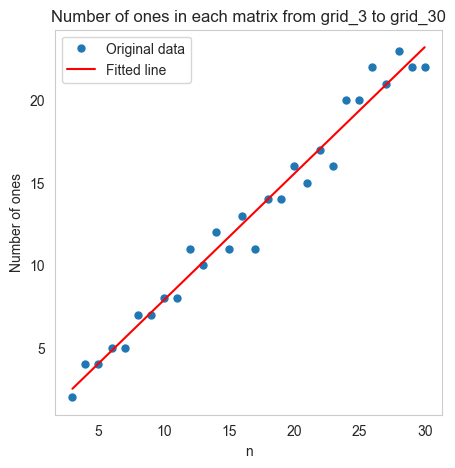

Slope of the line of best fit:  [0.76628352]


In [57]:
# Plot the line of best fit for the number of ones in each matrix from grid_3 to grid_30

ones = []
for i in range(3, 31):
    matrices = parse_timeline(i)
    ones.append([count_ones(matrix) for matrix in matrices])

ones = np.array(ones).reshape(-1,1)

x = np.arange(3, 31).reshape(-1,1)
y = ones

# Fit a line to the data using the least squares method
A = np.hstack([x, np.ones(x.shape)])
m, c = np.linalg.lstsq(A, y, rcond=None)[0]

plt.figure(figsize=(5, 5))
plt.plot(x, y, 'o', label='Original data', markersize=5)
plt.plot(x, m*x + c, 'r', label='Fitted line')
plt.xlabel('n')
plt.ylabel('Number of ones')
plt.title('Number of ones in each matrix from grid_3 to grid_30')
plt.legend()
plt.show()

# Print the slope of the line of best fit
print("Slope of the line of best fit: ", m)

In [68]:
# Take every grid_3, grid_4, ..., grid_30 and replace 0 with 1 and . with 0
# Then save the new matrices to a file called torus_grid_n.txt

for i in range(3, 5):
    matrices = parse_timeline(i)
    new_matrices = []
    for matrix in matrices:
        new_matrix = np.ones((i, i))
        for j in range(i):
            for k in range(i):
                if matrix[j][k] == 0:
                    new_matrix[j][k] = 1
        filename = f'torus_grid_{str(i)}.txt'
        filepath = os.path.join('Data', filename)
        np.savetxt(filepath, new_matrix, fmt='%d')



ValueError: invalid literal for int() with base 10: ' '